In [1]:
%%capture
try:
    import pandas  # noqa: F401
except ImportError:
    !pip install pandas

try:
    import numpy  # noqa: F401
except ImportError:
    !pip install numpy

try:
    import matplotlib  # noqa: F401
except ImportError:
    !pip install matplotlib

try:
    import sklearn  # noqa: F401
except ImportError:
    !pip install scikit-learn

try:
    import scipy  # noqa: F401
except ImportError:
    !pip install scipy

try:
    import torch  # noqa: F401
except ImportError:
    !pip install torch

try:
    import tqdm  # noqa: F401
except ImportError:
    !pip install tqdm

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

## Loading the Data

In [5]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv", parse_dates=["date"]
)
df = df.set_index("date")
df.index.freq = pd.infer_freq(df.index)
df.head(3)

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
date,,,,,,,
2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001


## Training Configuration 

In [6]:
TRAIN_FRACTION = 0.8
CONTEXT_LENGTH = 512
FORECAST_LENGTH = 96
STRIDE = 1
N_SAMPLE_TO_PLOT = 4
PAST_WINDOW = 100

## Preparing the Training Data

Data prepared from the data with a history and Forecast length `512` and `96` respectively, in a rolling window fashion.

In [9]:
data = df.OT.values
print(f"Data:\n{data}\n")


Data:
[30.53100014 27.78700066 27.78700066 ... 10.27099991  9.77799988
  9.56700039]



In [12]:
x = []

for i in range(1, len(data) - CONTEXT_LENGTH - FORECAST_LENGTH, STRIDE):
    x.append(data[i : (i + CONTEXT_LENGTH + FORECAST_LENGTH)])
    if i < 2:
       print(f"x:\n{x}")
    

x:
[array([27.78700066, 27.78700066, 25.04400063, 21.94799995, 21.17399979,
       22.79199982, 23.1439991 , 21.66699982, 17.44599915, 19.97900009,
       20.11899948, 19.20499992, 18.5720005 , 19.55599976, 17.30500031,
       19.48600006, 19.13400078, 20.68199921, 18.71199989, 17.86800003,
       18.00900078, 18.00900078, 19.76799965, 21.10400009, 19.6970005 ,
       20.04899979, 20.75200081, 21.38500023, 22.22999954, 20.26000023,
       21.10400009, 20.61199951, 18.36100006, 20.96299934, 19.41600037,
       20.82299995, 20.19000053, 21.31500053, 22.0189991 , 20.68199921,
       25.4659996 , 25.88800049, 27.85700035, 27.29500008, 22.22999954,
       21.94799995, 27.29500008, 29.33499908, 26.02799988, 24.34000015,
       26.45000076, 25.95800018, 24.05900002, 25.32500076, 23.63699913,
       26.37999916, 27.36499977, 28.06800079, 29.47500038, 26.80200005,
       29.96800041, 30.38999939, 31.16399956, 29.75699997, 32.28900146,
       31.93799973, 28.56100082, 21.52599907, 22.22999954, 1

In [14]:
x = np.array(x).astype(float)
print(f"x:\n{x}")

x:
[[27.78700066 27.78700066 25.04400063 ... 38.26900101 40.52000046
  40.94200134]
 [27.78700066 25.04400063 21.94799995 ... 40.52000046 40.94200134
  39.11299896]
 [25.04400063 21.94799995 21.17399979 ... 40.94200134 39.11299896
  39.95700073]
 ...
 [10.48200035  9.77799988  9.84899998 ... 10.19999981 10.90400028
  11.04399967]
 [ 9.77799988  9.84899998  9.91899967 ... 10.90400028 11.04399967
  10.27099991]
 [ 9.84899998  9.91899967 10.41100025 ... 11.04399967 10.27099991
   9.77799988]]


In [15]:
X, y = x[:, :CONTEXT_LENGTH], x[:, CONTEXT_LENGTH:]

train_length = int(TRAIN_FRACTION * len(X))

trainX, testX = X[:train_length], X[train_length:]
trainY, testY = y[:train_length], y[train_length:]

In [17]:
print(f"TrainX:\n{trainX}")
print(f"TrainY:\n{trainY}")

TrainX:
[[27.78700066 27.78700066 25.04400063 ... 35.03300095 38.62099838
  38.19800186]
 [27.78700066 25.04400063 21.94799995 ... 38.62099838 38.19800186
  37.2140007 ]
 [25.04400063 21.94799995 21.17399979 ... 38.19800186 37.2140007
  37.35400009]
 ...
 [ 2.53200006  2.39199996  2.6730001  ...  4.07999992  3.58800006
   3.44700003]
 [ 2.39199996  2.6730001   2.25099993 ...  3.58800006  3.44700003
   3.30599999]
 [ 2.6730001   2.25099993  2.53200006 ...  3.44700003  3.30599999
   3.86899996]]
TrainY:
[[37.2140007  37.35400009 37.63600159 ... 38.26900101 40.52000046
  40.94200134]
 [37.35400009 37.63600159 37.00299835 ... 40.52000046 40.94200134
  39.11299896]
 [37.63600159 37.00299835 37.49499893 ... 40.94200134 39.11299896
  39.95700073]
 ...
 [ 3.30599999  3.86899996  3.30599999 ...  1.68799996  1.75899994
   2.46199989]
 [ 3.86899996  3.30599999  3.51699996 ...  1.75899994  2.46199989
   4.50199986]
 [ 3.30599999  3.51699996  2.3210001  ...  2.46199989  4.50199986
   3.79900002]]


## Instantiating the RandomForestRegressor

Please feel free to change the `n_estimators` and `max_depth` parameter, and see their impact on the model forecast.

In [18]:
rf_model = RandomForestRegressor(
    n_estimators=50,
    max_depth=5,
    # n_jobs=4,
    verbose=2,
)

In [19]:
rf_model.fit(trainX, trainY)

building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   54.2s


building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


RandomForestRegressor(max_depth=5, n_estimators=50, verbose=2)

In [20]:
predictY = rf_model.predict(testX)

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


In [21]:
rmse = np.mean(np.sqrt(np.mean(np.square(testY - predictY), axis=-1)))
print(f"Prediction RMSE = {rmse:.4f}")

Prediction RMSE = 2.3473


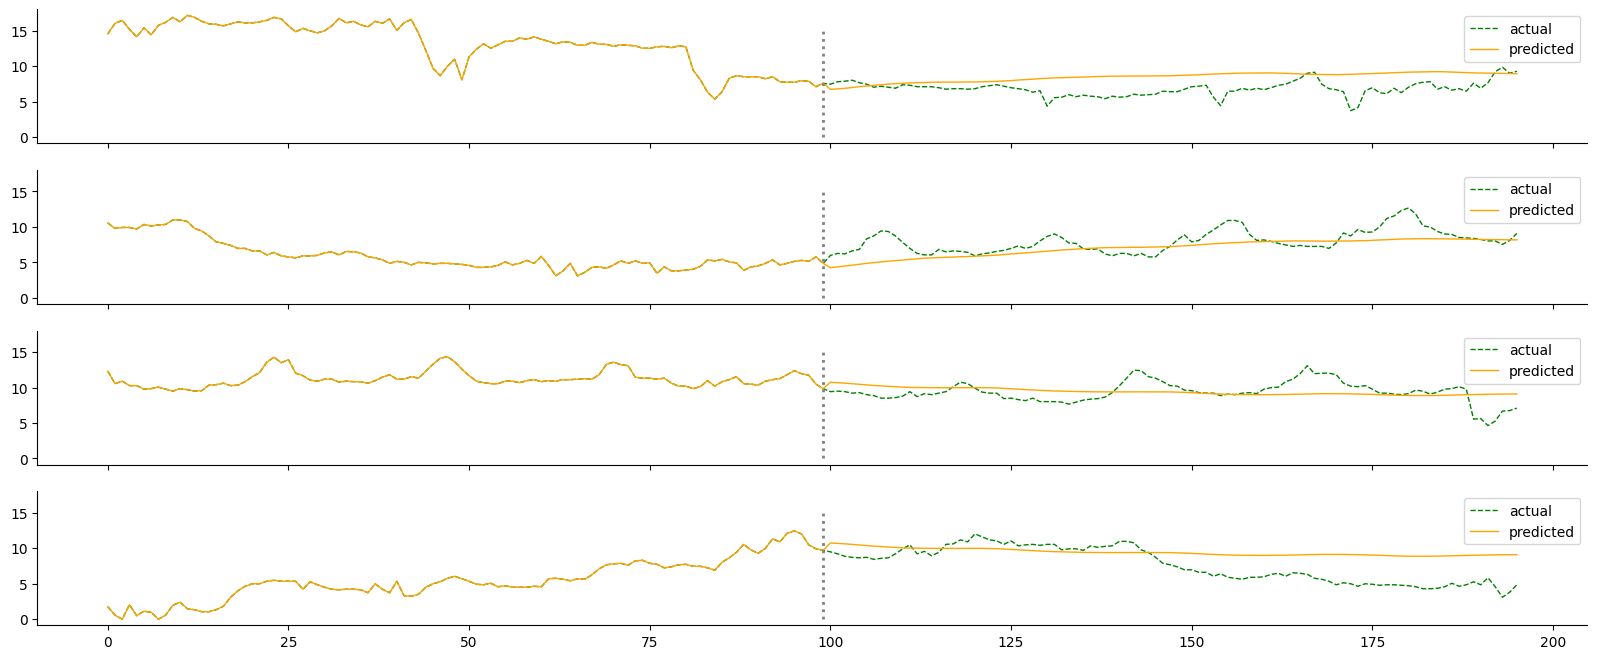

In [22]:
random_indices = np.random.default_rng(1).choice(len(testY), N_SAMPLE_TO_PLOT, replace=False)

fig, axs = plt.subplots(N_SAMPLE_TO_PLOT, 1, sharex="col", sharey=True, figsize=(20, 2 * N_SAMPLE_TO_PLOT))

for i, index in enumerate(random_indices):
    n_history = min(PAST_WINDOW, CONTEXT_LENGTH)
    y_true = np.concatenate([testX[index, -n_history:], testY[index]])
    y_pred = np.concatenate([testX[index, -n_history:], predictY[index]])
    axs[i].plot(y_true, color="green", linestyle="dashed", linewidth=1, label="actual")
    axs[i].plot(y_pred, color="orange", linewidth=1, label="predicted")
    for s in ["top", "right"]:
        axs[i].spines[s].set_visible(False)
    axs[i].plot([n_history - 1, n_history - 1], [0, 15], linewidth=2, linestyle="dotted", color="gray")
    axs[i].legend()

## Neural Network Example

In [23]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [24]:
border1s = [0, 12 * 30 * 24 - CONTEXT_LENGTH, 12 * 30 * 24 + 4 * 30 * 24 - CONTEXT_LENGTH]
border2s = [12 * 30 * 24, 12 * 30 * 24 + 4 * 30 * 24, 12 * 30 * 24 + 8 * 30 * 24]

In [25]:
data = df.OT.values.reshape(-1, 1)
scaler = StandardScaler()
train_data = data[border1s[0] : border2s[0], :]
scaler = StandardScaler()
scaler.fit(train_data)

data = scaler.transform(data)
train_data = data[border1s[0] : border2s[0], :]
valid_data = data[border1s[1] : border2s[1], :]
test_data = data[border1s[2] : border2s[2], :]

In [26]:
train_io_pairs = np.array(
    [
        train_data[i : (i + CONTEXT_LENGTH + FORECAST_LENGTH)]
        for i in range(1, len(train_data) - CONTEXT_LENGTH - FORECAST_LENGTH, STRIDE)
    ]
)
X_train = train_io_pairs[:, :CONTEXT_LENGTH]
y_train = train_io_pairs[:, CONTEXT_LENGTH:]

valid_io_pairs = np.array(
    [
        valid_data[i : (i + CONTEXT_LENGTH + FORECAST_LENGTH), 0]
        for i in range(1, len(valid_data) - CONTEXT_LENGTH - FORECAST_LENGTH, STRIDE)
    ]
)

X_valid = valid_io_pairs[:, :CONTEXT_LENGTH]
y_valid = valid_io_pairs[:, CONTEXT_LENGTH:]

test_io_pairs = np.array(
    [
        test_data[i : (i + CONTEXT_LENGTH + FORECAST_LENGTH), 0]
        for i in range(1, len(test_data) - CONTEXT_LENGTH - FORECAST_LENGTH, STRIDE)
    ]
)
X_test = test_io_pairs[:, :CONTEXT_LENGTH]
y_test = test_io_pairs[:, CONTEXT_LENGTH:]

## Dataset Class
This is an important class, as it prepare the data for the model.
Any online data clearning, reshaping, augmentation implementation, can be incorporated in this `Dataset` class instance.

In [27]:
class Data(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x).float()
        self.y = torch.from_numpy(y).float()
        self.len = self.x.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

## Simple 3 layer MLP


In [28]:
class CreateModel(nn.Module):
    def __init__(self, in_features, units, out_features):
        super(CreateModel, self).__init__()
        self.l1 = nn.Linear(in_features, units)
        self.l2 = nn.Linear(units, units)
        self.l3 = nn.Linear(units, out_features)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.tanh(self.l1(x))
        x = F.tanh(self.l2(x))
        x = self.l3(x)
        x = x.unsqueeze(-1)
        return x

## Preparing the data and model for training

In [29]:
HIDDEN_UNITS = 16
EPOCHS = 25

torch.manual_seed(42)
tr_data = Data(X_train, y_train)
tr_loader = DataLoader(dataset=tr_data, batch_size=64, shuffle=True)
nn_model = CreateModel(CONTEXT_LENGTH, HIDDEN_UNITS, FORECAST_LENGTH)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001)

In [30]:
loss_list = []
use_l1 = False

for t in range(EPOCHS):
    running_loss = 0
    pbar = tqdm(tr_loader)
    for i, data in enumerate(pbar):
        x_batch, y_batch = data
        y_pred = nn_model(x_batch)
        loss = criterion(y_pred, y_batch)
        if use_l1:
            l1_parameters = []
            for parameter in nn_model.parameters():
                l1_parameters.append(parameter.view(-1))
            l1_loss = torch.abs(torch.cat(l1_parameters)).mean()
            loss = loss + l1_loss
        nn_model.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pbar.set_description(f"Epoch[{t+1} : {i}/{len(tr_loader)}]: train_loss {running_loss/(i+1):.4f}")
    loss_list.append(running_loss / len(tr_loader))

Epoch[24 : 8/126]: train_loss 0.0878:   0%|                                                                                      | 0/126 [00:00<?, ?it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



## Plotting the loss convergence

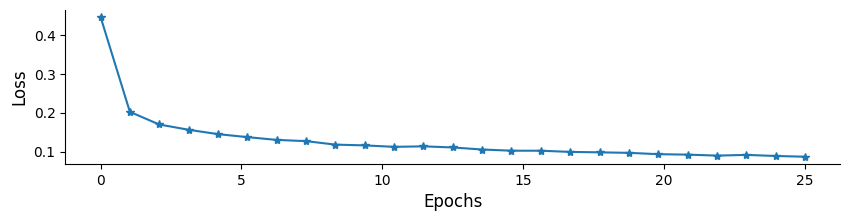

In [35]:
step = np.linspace(0, EPOCHS, EPOCHS)
fig, ax = plt.subplots(1, 1, figsize=(10, 2))
ax.plot(step, np.array(loss_list), marker="*")
for s in ["right", "top"]:
    ax.spines[s].set_visible(False)
ax.set_xlabel("Epochs", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
plt.show()

In [36]:
yp_test = nn_model(torch.from_numpy(X_test).float()).to("cpu").detach().numpy()

In [37]:
y_test_ = np.array([scaler.inverse_transform(y_[..., np.newaxis]) for y_ in y_test])
yp_test_ = np.array([scaler.inverse_transform(y_) for y_ in yp_test])

rmse = np.mean(np.sqrt(np.mean(np.square(y_test_ - yp_test_), axis=1)))
print(f"Prediction RMSE = {rmse:.4f}")

Prediction RMSE = 3.4723


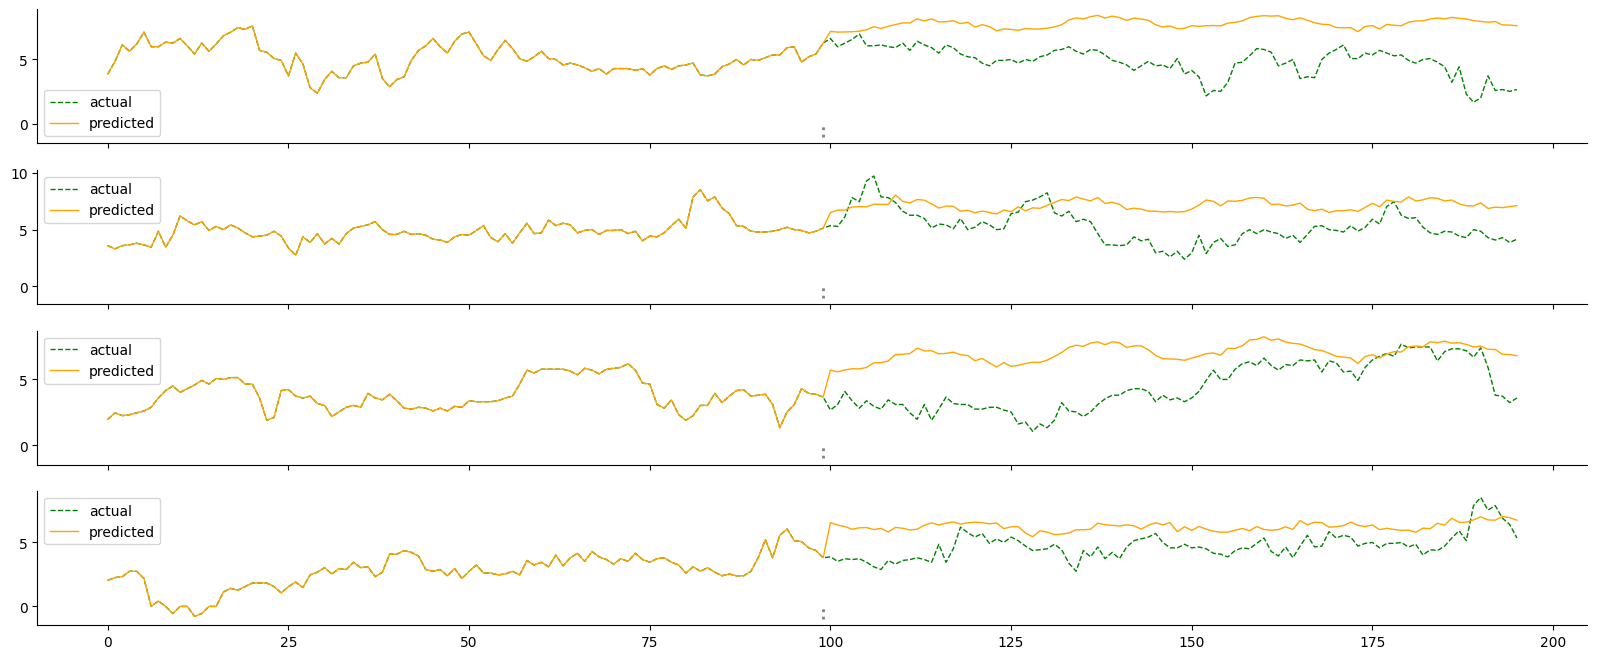

In [38]:
random_indices = np.random.default_rng(1).choice(len(y_test), N_SAMPLE_TO_PLOT, replace=False)

fig, axs = plt.subplots(N_SAMPLE_TO_PLOT, 1, sharex="col", figsize=(20, 2 * N_SAMPLE_TO_PLOT))

for i, index in enumerate(random_indices):
    n_history = min(PAST_WINDOW, CONTEXT_LENGTH)
    x_hist = scaler.inverse_transform(X_test[index, -n_history:].reshape(-1, 1))
    y_true = np.concatenate([x_hist[..., 0], y_test_[index, :, 0]], axis=0)
    y_true = y_true[..., np.newaxis]
    y_pred = np.concatenate([x_hist[..., 0], yp_test_[index, :, 0]], axis=0)
    y_pred = y_pred[..., np.newaxis]
    axs[i].plot(y_true, color="green", linestyle="dashed", linewidth=1, label="actual")
    axs[i].plot(y_pred, color="orange", linewidth=1, label="predicted")
    for s in ["top", "right"]:
        axs[i].spines[s].set_visible(False)
    axs[i].plot([n_history - 1, n_history - 1], [-1, 0], linewidth=2, linestyle="dotted", color="gray")
    axs[i].legend()